## Objective

- Build a ML model for the prediction of engine rating.
- Use the same model to detect outliers.

Steps to be follwed throughout:

Clean and Analyse Data >> Impute, Endcode and Scale values >> Train the model >> Hyperparameter optimization >> Get the best estimator by comparing evaluation criteria.

## Loading data into memory & Installing required libraries.

In [ ]:
# Installing Required Libraries
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
!pip install xgboost -q
import xgboost as xgb
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import GridSearchCV
import seaborn as sns
import matplotlib.pyplot as plt
import joblib

Kindly upoad the data file from the files section, make sure to have set the correct path and file name.

In [ ]:
df = pd.read_csv('/content/Leverage Edu __ Data Scientist - Assignment Data - data.csv', low_memory=False)

## EDA of Variables
Open Ended Exploratory Data Analysis of different features.

In [ ]:
df.shape

(26307, 73)

The data has a total of 26,307 rows along with 73 columns.

In [ ]:
print("The number of categorical columns are:")
print(len(df.select_dtypes(include=['object']).columns.tolist()))
print("The number of numerical columns are:")
print(len(df.select_dtypes(include=['int64','float64']).columns.tolist()))

The number of categorical columns are:
67
The number of numerical columns are:
6


The percentage of 'Null values' across the columns are as under.

In [ ]:
pd.set_option('display.max_rows', 75)

print((df.isnull().sum() * 100 / df.shape[0]).sort_values(ascending=False))

engineTransmission_engineOil_cc_value_9                      100.000000
engineTransmission_engine_cc_value_10                        100.000000
engineTransmission_clutch_cc_value_6                          99.996199
engineTransmission_engineOil_cc_value_8                       99.992397
engineTransmission_engine_cc_value_9                          99.988596
engineTransmission_battery_cc_value_4                         99.984795
engineTransmission_engine_cc_value_8                          99.984795
engineTransmission_clutch_cc_value_5                          99.973391
engineTransmission_coolant_cc_value_3                         99.969590
engineTransmission_engine_cc_value_7                          99.969590
engineTransmission_engineOil_cc_value_7                       99.958186
engineTransmission_comments_value_4                           99.946782
engineTransmission_battery_cc_value_3                         99.939180
engineTransmission_engine_cc_value_6                          99

Out of 73 only 18 columns have no null values rest all have mostly null values.


Let analyse the co-relation between numerical columns, out of 6 numerical columns, 2 are completely empty namely: 'engineTransmission_engineOil_cc_value_9' and 'engineTransmission_engine_cc_value_10'.

In [ ]:
df.corr()

<ipython-input-6-2f6f6606aa2c>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  df.corr()


,year,month,engineTransmission_engineOil_cc_value_9,engineTransmission_engine_cc_value_10,odometer_reading,rating_engineTransmission
year,1.000000,0.006427,NaN,NaN,-0.408025,0.586554
month,0.006427,1.000000,NaN,NaN,-0.010909,0.113765
engineTransmission_engineOil_cc_value_9,NaN,NaN,NaN,NaN,NaN,NaN
engineTransmission_engine_cc_value_10,NaN,NaN,NaN,NaN,NaN,NaN
odometer_reading,-0.408025,-0.010909,NaN,NaN,1.000000,-0.363312
rating_engineTransmission,0.586554,0.113765,NaN,NaN,-0.363312,1.000000


In [ ]:
df.describe()

,year,month,engineTransmission_engineOil_cc_value_9,engineTransmission_engine_cc_value_10,odometer_reading,rating_engineTransmission
count,26307.000000,26307.000000,0.0,0.0,26307.000000,26307.000000
mean,2010.856578,5.462006,NaN,NaN,76460.143764,3.624663
std,3.766234,3.583866,NaN,NaN,46762.524489,0.847645
min,1989.000000,1.000000,NaN,NaN,1.000000,0.500000
25%,2008.000000,2.000000,NaN,NaN,46396.000000,3.500000
50%,2011.000000,5.000000,NaN,NaN,72013.000000,4.000000
75%,2014.000000,9.000000,NaN,NaN,98289.500000,4.000000
max,2019.000000,12.000000,NaN,NaN,999999.000000,5.000000


- The data is for vehicles registered between the **year 1989** and the **year 2019.**

- The average rating for the engine Transmission (target column) is **3.62**

In [ ]:
print(df['inspectionStartTime'].min())
print(df['inspectionStartTime'].max())

1/10/19 10:18
4/9/19 9:46


The data is from inspections from date: **10-Jan-2019 to 9-Apr-2019**

In [ ]:
df['odometer_reading'][0:10]

0    124600
1     78108
2     93348
3     48233
4     74368
5     91916
6    121006
7     41534
8    152904
9     92340
Name: odometer_reading, dtype: int64

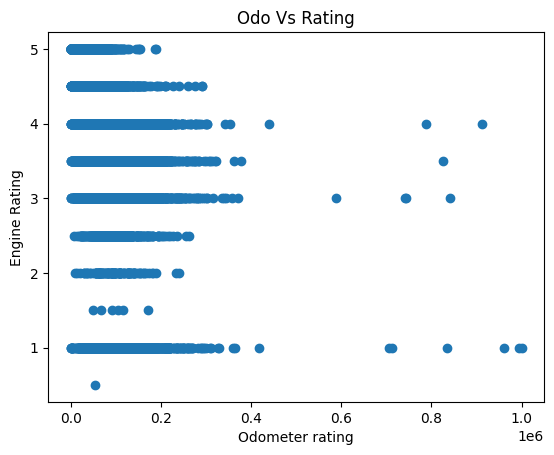

In [ ]:
plt.scatter(df['odometer_reading'], df['rating_engineTransmission'])
plt.title('Odo Vs Rating')
plt.xlabel('Odometer rating')
plt.ylabel('Engine Rating')
plt.show()

The rating of **1.5** is significantly less and can be found in cars having odometer rating between 10,000 to 20,000*

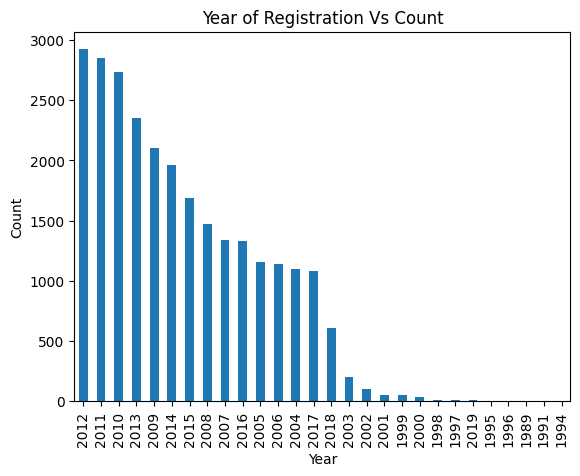

In [ ]:
df.year.value_counts().plot.bar()
plt.title('Year of Registration Vs Count')
plt.xlabel('Year')
plt.ylabel('Count')
plt.show()

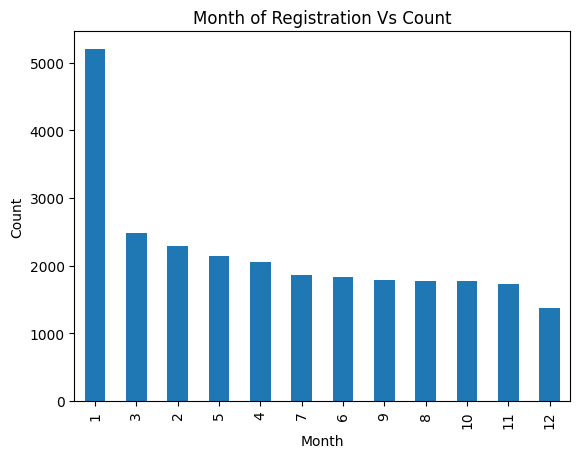

In [ ]:
df.month.value_counts().plot.bar()
plt.title('Month of Registration Vs Count')
plt.xlabel('Month')
plt.ylabel('Count')
plt.show()

Seems like January has the highest number of registrations.

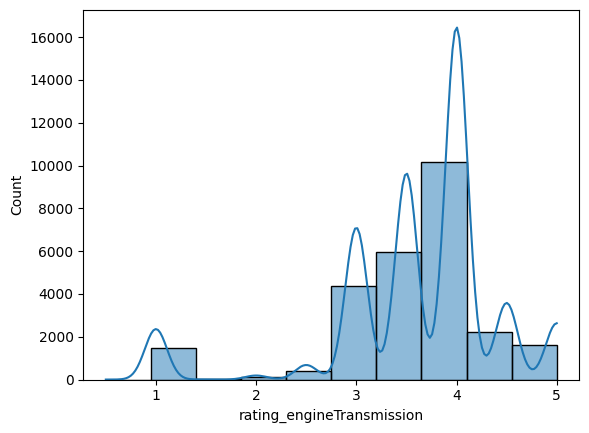

In [ ]:
sns.histplot(data=df, x='rating_engineTransmission', bins=10, kde=True)
plt.show()

The highest count of rating is roughly in between 3.5 to 4.1.


## Data Cleaning and Preparation for Model Trainig.

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26307 entries, 0 to 26306
Data columns (total 73 columns):
 #   Column                                                     Non-Null Count  Dtype  
---  ------                                                     --------------  -----  
 0   appointmentId                                              26307 non-null  object 
 1   inspectionStartTime                                        26307 non-null  object 
 2   year                                                       26307 non-null  int64  
 3   month                                                      26307 non-null  int64  
 4   engineTransmission_battery_value                           26307 non-null  object 
 5   engineTransmission_battery_cc_value_0                      3438 non-null   object 
 6   engineTransmission_battery_cc_value_1                      430 non-null    object 
 7   engineTransmission_battery_cc_value_2                      72 non-null     object 
 8   engine

Mostly columns are cateforical, since rows >> columns, we would be dropping some columns which have very low number of entries(< 50)

In [ ]:
df = df.drop(['engineTransmission_comments_value_4', 'engineTransmission_clutch_cc_value_6', 'engineTransmission_clutch_cc_value_5', 'engineTransmission_coolant_cc_value_3', 'engineTransmission_engine_cc_value_10', 'engineTransmission_engine_cc_value_9', 'engineTransmission_engine_cc_value_8', 'engineTransmission_engine_cc_value_7' , 'engineTransmission_engineOil_cc_value_9' , 'engineTransmission_engineOil_cc_value_8', 'engineTransmission_battery_cc_value_3', 'engineTransmission_battery_cc_value_4','appointmentId',
 'inspectionStartTime'],axis=1)

In [ ]:
categorical_columns = df.select_dtypes(include=['object']).columns.tolist()
numerical_columns = df.select_dtypes(include=['int64','float64']).columns.tolist()

In [ ]:
df[categorical_columns] = df[categorical_columns].fillna('Unkown')

In [ ]:
df.isnull().sum().value_counts()

0    61
dtype: int64

Now there is no null value present in the data frame.

In [ ]:
# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(df.iloc[:,0:-1], df.iloc[:,-1], test_size=0.3, random_state=42)

In [ ]:
#Scaling and encoding the train data

transformer = make_column_transformer(
    (StandardScaler(), ['odometer_reading']),
    (OneHotEncoder(), categorical_columns), remainder='passthrough')

X_train = transformer.fit_transform(X_train)

In [ ]:
#Scaling and encoding the test data

transformer_t = make_column_transformer(
    (StandardScaler(), ['odometer_reading']),
    (OneHotEncoder(), categorical_columns), remainder='passthrough')

X_test = transformer_t.fit_transform(X_test)

In [ ]:
def fixing_extra_cols(X_train, X_test):

  f_names = transformer.get_feature_names_out()
  f_names_t = transformer_t.get_feature_names_out()
  not_present = []
  f_names_to_remove_train = []
  f_names_to_remove_test = []
  not_present_2 = []


  for i,c in enumerate(f_names):
    if c not in f_names_t:
      not_present.append(i)
      f_names_to_remove_train.append(c)


  for i,c in enumerate(f_names_t):
    if c not in f_names:
      not_present_2.append(i)
      f_names_to_remove_test.append(c)

  revised_index = list(range(0, X_train.shape[1]))
  revised_index_t = list(range(0, X_test.shape[1]))

  for i in not_present:
    revised_index.remove(i)

  for i in not_present_2:
    revised_index_t.remove(i)

  X_train = X_train[:,revised_index]
  X_test = X_test[:, revised_index_t]

  f_names = np.setdiff1d(f_names, f_names_to_remove_train)
  f_names_t = np.setdiff1d(f_names_t, f_names_to_remove_test)

  print("Sucessfully removed the extra columns in the Train and Test set")
  print("Train data shape: {} , Test data shape {}".format(X_train.shape, X_test.shape))

  return X_train, X_test, f_names

## Model Building

In [ ]:
X_train, X_test, f_names = fixing_extra_cols(X_train, X_test)

Sucessfully removed the extra columns in the Train and Test set
Train data shape: (18414, 283) , Test data shape (7893, 283)


In [ ]:
xgbr = xgb.XGBRegressor()
xgbr.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [ ]:
y_pred = xgbr.predict(X_test)

In [ ]:
mean_absolute_error(y_test, y_pred)

0.3251386417169678

## Hyper-Parameter Tuning

In [ ]:
%%time

param_grid = {
    'max_depth': [3, 5, 7],
    'learning_rate': [0.1, 0.01, 0.001],
    'subsample': [0.5, 0.7, 1],
    'n_estimators': [50, 100, 150, 200],
    'min_child_weight': [1,2,4,8],
    'reg_alpha': [0,5,10],
    }

# Create the GridSearchCV object
grid_search = GridSearchCV(xgbr, param_grid, cv=3, scoring='neg_mean_absolute_error')

# Fit the GridSearchCV object to the training data
grid_search.fit(X_train, y_train)

CPU times: user 1h 8min 24s, sys: 21.4 s, total: 1h 8min 45s
Wall time: 38min 26s


GridSearchCV(cv=3,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, device=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None,
                                    grow_policy=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, m...
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None,
                                    multi_strategy=None, n_estimators=None,
                                    n_jobs=None, num_parallel_tree=None,
                                    random_state=None, ...),
             param_grid={'learning_rate': [0.1, 0.01, 0.001],
                         'max_depth': [3, 5, 7],
                         'min_child_weight': [1, 2, 4, 8],
                         'n_estimators': [50, 100, 150, 200],
                         'reg_alpha': [0, 5, 10], 'subsample': [0.5, 0.7, 1]},
             scoring='neg_mean_absolute_error')

In [ ]:
y_pred = grid_search.predict(X_test)
mean_absolute_error(y_test, y_pred)
print(mean_absolute_error(y_test, y_pred))

0.3163560903749734


In [ ]:
grid_search.best_params_

{'learning_rate': 0.1,
 'max_depth': 7,
 'min_child_weight': 2,
 'n_estimators': 150,
 'reg_alpha': 0,
 'subsample': 0.7}

## Exporting the best Model

In [ ]:
final_model = xgb.XGBRegressor(learning_rate = 0.1,
 max_depth= 7,
 min_child_weight= 2,
 n_estimators= 150,
 reg_alpha= 0,
 subsample= 0.7)

final_model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=7, max_leaves=None,
             min_child_weight=2, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=150, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [ ]:
joblib.dump(final_model, 'model.joblib')

['model.joblib']

In [ ]:
error = y_pred - y_test

## Using this model to detect outlier.

The average mean absolute error is 0.316, hence we will try to detect cases where the value he differnce is atleast 0.5.

In [ ]:
#Load in a new csv file for test purposes.
#df = pd.read_csv('')
#df = df.drop(['engineTransmission_comments_value_4', 'engineTransmission_clutch_cc_value_6', 'engineTransmission_clutch_cc_value_5', 'engineTransmission_coolant_cc_value_3', 'engineTransmission_engine_cc_value_10', 'engineTransmission_engine_cc_value_9', 'engineTransmission_engine_cc_value_8', 'engineTransmission_engine_cc_value_7' , 'engineTransmission_engineOil_cc_value_9' , 'engineTransmission_engineOil_cc_value_8', 'engineTransmission_battery_cc_value_3', 'engineTransmission_battery_cc_value_4','appointmentId','inspectionStartTime'],axis=1)

In [ ]:
X_input = df.iloc[:,0:-1]

X_train, X_test, y_train, y_test = train_test_split(df.iloc[:,0:-1], df.iloc[:,-1], test_size=0.3, random_state=42)

transformer = make_column_transformer(
    (StandardScaler(), ['odometer_reading']),
    (OneHotEncoder(), categorical_columns), remainder='passthrough')

X_train = transformer.fit_transform(X_train)

transformer_t = make_column_transformer(
    (StandardScaler(), ['odometer_reading']),
    (OneHotEncoder(), categorical_columns), remainder='passthrough')

X_input = transformer_t.fit_transform(X_input)

X_train, X_input, f_names = fixing_extra_cols(X_train, X_input)

y_pred = final_model.predict(X_input)

Sucessfully removed the extra columns in the Train and Test set
Train data shape: (18414, 291) , Test data shape (26307, 291)


In [ ]:
df['Predicted_values'] = y_pred

In [ ]:
data = df[abs(df['Predicted_values'] - df['rating_engineTransmission']) > 2.0]
data.to_csv('outliers.csv', index=False)

In [ ]:
!pip freeze > requirements.txt